## Import libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
from srs.analysis import read_data, plot_missing_values, plot_max_median, plot_correlation_between_stations, \
    remove_outliers, interpolate_missing_values, calculate_mean_value_across_all_stations, save_mean_data, \
    plot_change_between_consecutive_hours, plot_diff_between_stations

## Read data

In [3]:
data = read_data('NO')
stations = data.columns.tolist()[1:]

In [4]:
stations

['WpPoznDabrow', 'WpPoznPolank', 'WpPoznRatajeMOB']

In [5]:
data

Time  WpPoznDabrow  WpPoznPolank  WpPoznRatajeMOB
0    2020-01-01 00:00:00       1.12923       1.67319          0.07056
1    2020-01-01 01:00:00       1.50748       1.45381          0.09504
2    2020-01-01 02:00:00       1.30589       1.54059          0.09920
3    2020-01-01 03:00:00       1.42470       1.49931          0.07080
4    2020-01-01 04:00:00       1.13304       1.45977          0.07565
...                  ...           ...           ...              ...
8779 2020-12-31 19:00:00      23.94140      10.02030         39.78760
8780 2020-12-31 20:00:00      13.08280       7.07776         29.75930
8781 2020-12-31 21:00:00      10.15090       4.56087         43.53170
8782 2020-12-31 22:00:00       5.20830       4.20344         27.52820
8783 2020-12-31 23:00:00       6.35104       1.80410          2.92941

[8784 rows x 4 columns]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Time             8784 non-null   datetime64[ns]
 1   WpPoznDabrow     8680 non-null   float64       
 2   WpPoznPolank     8691 non-null   float64       
 3   WpPoznRatajeMOB  8767 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 274.6 KB


In [7]:
data.describe().T

count      mean        std      min       25%       50%  \
WpPoznDabrow     8680.0  6.957377  20.484727  0.11431  1.031630  2.134965   
WpPoznPolank     8691.0  5.666209  13.300741  0.01686  0.531065  1.550930   
WpPoznRatajeMOB  8767.0  4.290249  11.776472  0.01074  0.279710  0.980970   

                      75%      max  
WpPoznDabrow     4.897560  418.139  
WpPoznPolank     4.796755  290.615  
WpPoznRatajeMOB  3.180025  215.746

### Investigate missing values

In [8]:
data.isnull().mean().round(3)

Time               0.000
WpPoznDabrow       0.012
WpPoznPolank       0.011
WpPoznRatajeMOB    0.002
dtype: float64

In [9]:
plot_missing_values(data, stations)

The missing values are spread throught the whole data range, these should be easy to interpolate.

## EDA

**Maximum and median values**

In [10]:
plot_max_median(data, stations)

It looks like there are just moments throughout the day when the concentration is very high, but it does not last long.

**Correlation between stations**

The data has to be transformed for the pattern to occur.

In [11]:
data_log = data.copy()

for s in stations:
    data_log[s] = np.log(data[s])

In [12]:
plot_correlation_between_stations(data_log, stations[0], stations[1])

In [13]:
plot_correlation_between_stations(data_log, stations[0], stations[2])

In [14]:
plot_correlation_between_stations(data_log, stations[1], stations[2])

What's interesting, the measurements of stations are not linearly correlated. I had to make logarytmic transformation to see the pattern.

**Change between consecutive hours**

In [15]:
plot_change_between_consecutive_hours(data, stations)

                Difference                               
                      mean   median        max        std
Parameter                                                
WpPoznDabrow     -0.004658 -0.05127  276.43200  12.611867
WpPoznPolank     -0.003491 -0.02689  117.53311   7.835788
WpPoznRatajeMOB  -0.004792 -0.01420  129.82360   6.532970


This distribution is not surprising after the observation we made when analysing max and median values. There rapid changes in pollution which happen from time to time.

**Difference between stations**

In [16]:
plot_diff_between_stations(data, stations[0], stations[1])

mean       -1.308166
median     -0.397860
max       141.421140
std        14.978826
Name: Difference, dtype: float64


In [17]:
plot_diff_between_stations(data, stations[0], stations[2])

mean       -2.686242
median     -0.936550
max       121.146900
std        13.501442
Name: Difference, dtype: float64


In [18]:
plot_diff_between_stations(data, stations[1], stations[2])

mean       -1.373787
median     -0.306530
max       124.464600
std        10.747067
Name: Difference, dtype: float64


There is a factor which disturbes the normal distribution and skews it towards one side.

## Remove outliers

As there are many sudden changes in data, removing outliers is more tricky here. I will increase the threshold to not remove valuable information.

In [27]:
data_rm_outliers = remove_outliers(data, stations, num_std=6)
data_rm_outliers = interpolate_missing_values(data_rm_outliers, stations)

76 outliers removed for WpPoznDabrow
17 outliers removed for WpPoznPolank
5 outliers removed for WpPoznRatajeMOB
161 values interpolated for WpPoznDabrow
110 values interpolated for WpPoznPolank
16 values interpolated for WpPoznRatajeMOB


The interploation filled missing data only up to 3 concurrent hours and this limit was chosen based on intuiton of the analyst.

How many missing values are left?

In [28]:
data.isnull().sum()

Time                 0
WpPoznDabrow       104
WpPoznPolank        93
WpPoznRatajeMOB     17
dtype: int64

In [29]:
data_rm_outliers.isnull().sum()

Time                0
WpPoznDabrow       19
WpPoznPolank        0
WpPoznRatajeMOB     6
dtype: int64

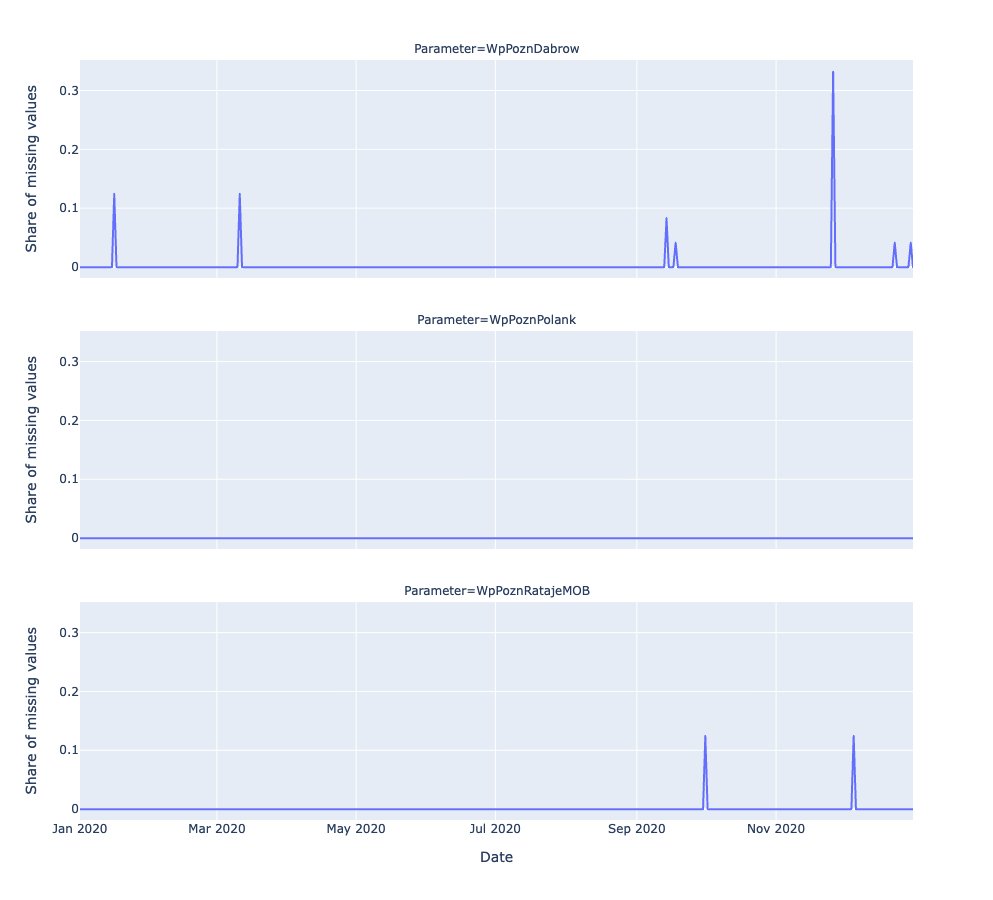

In [30]:
plot_missing_values(data_rm_outliers, stations)

## Calculate final mean value across all the stations

In [31]:
data_mean = calculate_mean_value_across_all_stations(data_rm_outliers, 'NO')

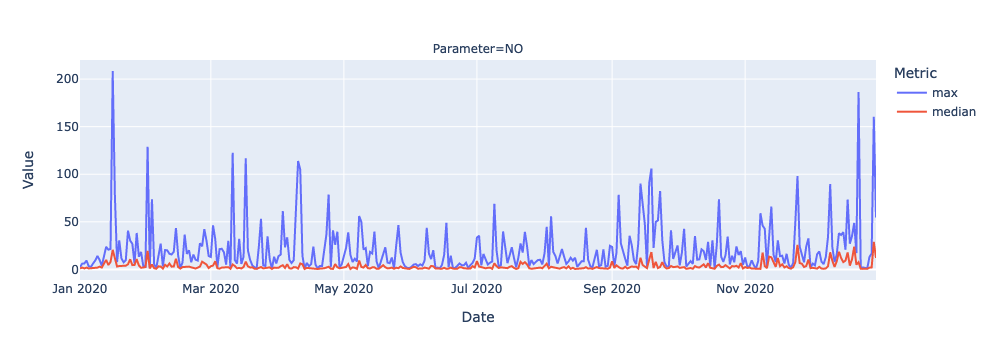

In [32]:
plot_max_median(data_mean, ['NO'])

In [33]:
data_mean.isnull().sum()

Time    0
NO      0
dtype: int64

With data from both stations we covered the entire year.

**Save mean data**

In [34]:
save_mean_data(data_mean, 'NO')